In [1]:
from langchain_openai import OpenAI,ChatOpenAI

llm=ChatOpenAI(
  model="qwen2.5-coder-1.5b-instruct",
  openai_api_key="EMPTY",
  base_url="http://127.0.0.1:1234/v1",
  temperature=0.7
)

In [2]:
promptTemplate = """尽可能帮助用户回答任何的问题。

您可以使用以下工具来帮忙解决问题，如果已经知道了答案，也可以直接回答。

{tools}

回复我时，请以下面2种格式之一进行回复：

格式1：如果你希望使用工具，请使用此JSON格式回复内容：
{{
    "reason": string, //叙述使用工具的原因
    "action": string, //要使用的工具。必须是 {tool_names} 之一
    "action_input": string //工具的输入
}}

格式2：如果你认为你已经有答案或者已经通过使用工具找到了答案，想直接对用户的输入作出回复，请使用此JSON格式回复：
{{
    "action": "Final Answer",
    "answer": string //最终回复问题的答案放在这里
}}

下面是用户的输入，请记住只回复上面的2种格式的其中1种，必须以json格式回复，不要回复其他内容。
用户的输入：{input}
"""

In [3]:
from langchain_core.prompts import ChatPromptTemplate,MessagesPlaceholder

prompt=ChatPromptTemplate.from_messages(
  [
    ("system","你是非常强大的助手，你可以使用各种工具来完成人类交给的问题和任务"),
    ("user",promptTemplate),
    MessagesPlaceholder(variable_name="agent_scratchpad")
  ]
)

In [4]:
from langchain_community.utilities import SearxSearchWrapper
from langchain.agents import Tool

search=SearxSearchWrapper(
    searx_host="http://127.0.0.1:6688",
    k=5,
)

search_search=Tool(
    name="Search",
    func=search.run,
    description="useful for when you want to answer questions about current events"
)

In [5]:
search_search.invoke("房东的猫")

"The Landlord's Cat (房東的貓). CHNAsian, Chinese Folk. 109,200 monthly listeners. 58.7K followers. 48.5K subscribers. 20 fans. The Landlord's Cat (房東的\xa0...\n\nExplore 房东的猫's biography, discography, and artist credits. Shop rare vinyl records, top albums, and more on Discogs.\n\nAug 3, 2021 ... Stream 房东的猫 - New Boy by terencetzc on desktop and mobile. Play over 320 million tracks for free on SoundCloud.\n\nJul 7, 2024 ... Fang Dong De Mao (房东的猫) – My Dearest Passerby | As Beautiful As You《你比星光美丽》OST Lyrics Eng/Indo.\n\nMar 18, 2025 ... 房东的猫 · 房东的猫. 2017. 少年时- Single."

In [6]:
from langchain.agents import tool

In [47]:
import os
import requests

@tool
def get_weather(location):
    """根据城市获取天气数据"""
    api_key = os.getenv("WEATHER_API_KEY")
    url = f"https://api.seniverse.com/v3/weather/now.json?key={api_key}&location={location}&language=zh-Hans&unit=c"
    response=requests.get(url)
    print(location)
    if response.status_code==200:
        data=response.json()
        weather={
            'description':data['results'][0]['now']['text'],
            'temperature':data['results'][0]['now']['temperature']
        }
        return weather
    else:
        raise Exception(f"失败接收天气信息：{response.status_code}")

In [8]:
tools=[get_weather,search_search]

In [9]:
from langchain.tools.render import render_text_description

prompt=prompt.partial(
    tools=render_text_description(tools),
    tool_names=", ".join([t.name for t in tools])
)

prompt

ChatPromptTemplate(input_variables=['agent_scratchpad', 'input'], input_types={'agent_scratchpad': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], typing.Ann

In [10]:
from langchain_core.output_parsers.json import parse_json_markdown

In [11]:
def jsonParser(message):
    return parse_json_markdown(message.content)

chain=prompt | llm | jsonParser

In [12]:
result=chain.invoke({
    "input":"房东的猫最近有什么活动",
    "agent_scratchpad":[]
})
result

{'reason': '用户询问房东的猫最近有哪些活动',
 'action': 'Search',
 'action_input': 'https://www.example.com/search?q=房东的猫&category=cats+activities'}

In [13]:
def isUseTool(obj):
    if obj["action"]=="Final Answer":
        return end
    else:
        for tool in tools:
            if obj["action"]==tool.name:
                print(obj["action_input"])
                return tool.invoke(obj["action_input"])
            
isUseTool(result)

https://www.example.com/search?q=房东的猫&category=cats+activities


'No good search result found'

In [14]:
tool_response_prompt = """工具响应：
-------
[{{'title': '2023年刘亦菲宝格丽的三次活动',
  'content': '2023年12月24日 - 刘亦菲最近造型团队摸到灵感了，她的五官和身材特点特别适合油画风。自从前时期柳宗源拍了这个系列之后的活动',
  'url': 'https://m.163.com/dy/article/IMOEG9KF05562JCP.html'}},
 {{'title': '刘亦菲最近活动',
  'content': '12月21日，刘亦菲出席澳门国际电影节活动造型曝光，照片中，刘亦菲身穿一袭天蓝色抹胸连衣裙，外搭同色系披风，性感又迷人。',
  'url': 'https://www.toutiao.com/keyword/214095189'}},
 {{'title': '刘亦菲百万穿搭亮相宝格丽活动，生图暴露麒麟臂',
  'content': '2023年11月16日 - 最近，女星刘亦菲现身牌照活动，早在开场之前，大家就对刘亦菲的现场状态充满期待。刘亦菲团队方面也早早放出美',
  'url': 'https://www.163.com/dy/article/IJMSVED405179RJN.html'}}]
-------

请根据工具的响应判断，是否能够回答问题：

{input}

请根据工具响应的内容，思考接下来回复。回复格式严格按照前面所说的2种JSON回复格式，选择其中1种进行回复。请记住只选择单个选项格式，以JSON格
"""

In [15]:
from langchain_core.messages import HumanMessage,AIMessage

query="刘亦菲最近有什么活动"
agent_scratchpad=[
    AIMessage("{'reson':'用户询问了关于刘亦菲最近的活动信息，我需要搜索来获取答案','action':'searxng_search','action_input':'刘亦菲最近活动'}"),
    HumanMessage(
        content=tool_response_prompt.format(input=query),
    )
]

chain=prompt | llm
result=chain.invoke({
    "input":"刘亦菲最近有什么活动",
    "agent_scratchpad":agent_scratchpad
})
result

AIMessage(content='{\n    "action": "Final Answer",\n    "answer": "刘亦菲最近的活动包括出席澳门国际电影节、参加牌照活动和现身宝格丽活动。"\n}', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 693, 'total_tokens': 731, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'qwen2.5-coder-1.5b-instruct', 'system_fingerprint': 'qwen2.5-coder-1.5b-instruct', 'id': 'chatcmpl-vg71low8axl87lf0eudtj7', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--019bc798-3e60-71c0-901f-aae2b73d0233-0', usage_metadata={'input_tokens': 693, 'output_tokens': 38, 'total_tokens': 731, 'input_token_details': {}, 'output_token_details': {}})

In [22]:
from langgraph.graph import END,StateGraph,MessageGraph
from typing import List,Annotated,TypedDict
import operator

class GState(TypedDict):
    messages: Annotated[List,operator.add]

In [23]:
def isUseTool(gState):
    print("isUseTool-------------")
    print(gState)
    obj=gState["messages"][-1]
    if obj["action"]=="Final Answer":
        return END
    else:
        return "toolNode"

def useTool(gState):
    print("UseTool-------------")
    print(gState)
    obj=gState["messages"][-1]
    for tool in tools:
        if obj["action"]==tool.name:
            return {"messages":[tool.invoke(obj["action_input"])]}
    print("找不到对应的工具名称：",obj["action"])

In [40]:
import json

agentGraph=StateGraph(GState)

def startParse(gState):
    print("startParse-------------")
    print(gState)
    tool_response_prompt = """工具响应：
-------
{tools_response}
-------

请根据工具的响应判断，是否能够回答问题：

{input}

请根据工具响应的内容，思考接下来回复。回复格式严格按照前面所说的2种JSON回复格式，选择其中1种进行回复。请记住只选择单个选项格式，以JSON格式回复，不要回复其他内容。
"""

    if len(gState["messages"]) > 1:
        # agent_scratchpad 用于存储 Agent 的思考过程和工具返回结果
        agent_scratchpad = [
            # 取出倒数第二条消息（通常是 AI 的思考/工具调用意图）
            AIMessage(content=json.dumps(gState["messages"][-2])),
            # 构建当前的工具响应消息
            HumanMessage(
                content = tool_response_prompt.format(
                    input=gState["messages"][0], # 初始用户输入
                    tools_response=json.dumps(gState["messages"][-1]) # 刚刚获取的工具结果
                ),
            )
        ]
    else:
        agent_scratchpad = []

    return {
        "input": gState["messages"][0],
        "agent_scratchpad": agent_scratchpad
    }
    
def startMsgParse(message):
    message=message.content.replace("'",'"')
    message=parse_json_markdown(message)
    
    return {"messages":[message]}

agentGraph.add_node("startNode",startParse | prompt | llm | startMsgParse)
agentGraph.add_node("toolNode",useTool)
agentGraph.set_entry_point("startNode")

agentGraph.add_conditional_edges("startNode",isUseTool,{
    "toolNode":"toolNode",
    END:END
})


agentGraph.add_edge("toolNode","startNode")
agent=agentGraph.compile()

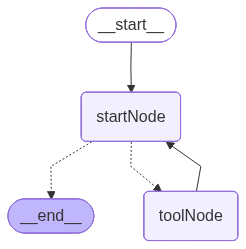

In [34]:
from IPython.display import Image, display

display(Image(agent.get_graph().draw_mermaid_png()))

In [42]:
agent.invoke({"messages":["刘亦菲最近有什么活动"]})

startParse-------------
{'messages': ['刘亦菲最近有什么活动']}
isUseTool-------------
{'messages': ['刘亦菲最近有什么活动', {'reason': '用户希望了解刘亦菲近期的活动。', 'action': 'Search', 'action_input': '刘亦菲 最近的活动'}]}
UseTool-------------
{'messages': ['刘亦菲最近有什么活动', {'reason': '用户希望了解刘亦菲近期的活动。', 'action': 'Search', 'action_input': '刘亦菲 最近的活动'}]}
startParse-------------
{'messages': ['刘亦菲最近有什么活动', {'reason': '用户希望了解刘亦菲近期的活动。', 'action': 'Search', 'action_input': '刘亦菲 最近的活动'}, "Dec 4, 2025 ... 现场众星云集，品牌代言人 #Lisa #刘亦菲 #HoYeonJung #Koki #钟楚曦 ... 如果你有在追她最近的行程，就會發現線索早就鋪好鋪滿。 從首爾《Louis\xa0...\n\n\n\n深入刘亦菲的艺术世界，探讨她在《Marie Claire》的最新话题和人物观点 ... 最近 陈都灵 新闻, 参与 央视活动, 娱乐圈 控制论. 23.9K Likes, 191\xa0...\n\n\n\nMake the most of every shot. As the Official Professional Services Provider of the PGA TOUR, Grant Thornton gives you access to the TPC Network's\xa0..."]}
isUseTool-------------
{'messages': ['刘亦菲最近有什么活动', {'reason': '用户希望了解刘亦菲近期的活动。', 'action': 'Search', 'action_input': '刘亦菲 最近的活动'}, "Dec 4, 2025 ... 现场众星云集，品牌代言人 #Lisa #刘亦菲 #H

{'messages': ['刘亦菲最近有什么活动',
  {'reason': '用户希望了解刘亦菲近期的活动。',
   'action': 'Search',
   'action_input': '刘亦菲 最近的活动'},
  "Dec 4, 2025 ... 现场众星云集，品牌代言人 #Lisa #刘亦菲 #HoYeonJung #Koki #钟楚曦 ... 如果你有在追她最近的行程，就會發現線索早就鋪好鋪滿。 從首爾《Louis\xa0...\n\n\n\n深入刘亦菲的艺术世界，探讨她在《Marie Claire》的最新话题和人物观点 ... 最近 陈都灵 新闻, 参与 央视活动, 娱乐圈 控制论. 23.9K Likes, 191\xa0...\n\n\n\nMake the most of every shot. As the Official Professional Services Provider of the PGA TOUR, Grant Thornton gives you access to the TPC Network's\xa0...",
  {'action': 'Final Answer',
   'answer': '刘亦菲的艺术世界，探讨她在《Marie Claire》的最新话题和人物观点 ... 最近 陈都灵, 参与 央视活动, 娱乐圈 控制论. 23.9K Likes, 191\xa0...'}]}

In [49]:
agent.invoke({"messages":["上海的天气"]})

startParse-------------
{'messages': ['上海的天气']}
isUseTool-------------
{'messages': ['上海的天气', {'reason': '需要获取上海的天气数据', 'action': 'get_weather', 'action_input': '上海'}]}
UseTool-------------
{'messages': ['上海的天气', {'reason': '需要获取上海的天气数据', 'action': 'get_weather', 'action_input': '上海'}]}
上海
startParse-------------
{'messages': ['上海的天气', {'reason': '需要获取上海的天气数据', 'action': 'get_weather', 'action_input': '上海'}, {'description': '雾', 'temperature': '10'}]}
isUseTool-------------
{'messages': ['上海的天气', {'reason': '需要获取上海的天气数据', 'action': 'get_weather', 'action_input': '上海'}, {'description': '雾', 'temperature': '10'}, {'action': 'Final Answer', 'answer': '上海天气数据 10컌的子榯'}]}


{'messages': ['上海的天气',
  {'reason': '需要获取上海的天气数据', 'action': 'get_weather', 'action_input': '上海'},
  {'description': '雾', 'temperature': '10'},
  {'action': 'Final Answer', 'answer': '上海天气数据 10컌的子榯'}]}